## START


In [15]:
%reset -f

In [16]:
# === Dipendenze ===
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import osmnx as ox

try:
    import contextily as ctx
    HAS_CTX = True
except Exception:
    HAS_CTX = False

ox.settings.use_cache = True
ox.settings.log_console = False
ox.settings.timeout = 180

# === Parametri ===
BASEMAP_PROVIDERS = {
    "positron": ctx.providers.CartoDB.Positron,
    "dark": ctx.providers.CartoDB.DarkMatter,
    "osm": ctx.providers.OpenStreetMap.Mapnik,
    "satellite": ctx.providers.Esri.WorldImagery,
}

PARAMS = {
    "center_latlon": (41.940583, 12.418912),  # Santa Maria della Pietà
    "dist_m": 5000,                           # raggio in metri
    "crs_metric": "EPSG:32633",               # UTM 33N
    "use_basemap": True,                      # usa una basemap se contextily è disponibile
    "basemap": "positron"                     # scegli tra: positron, toner, terrain, osm, satellite
}



In [17]:
# === 1. AOI: buffer metrico attorno al punto ===
lat, lon = PARAMS["center_latlon"]
gdf_pt = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs=4326)
aoi_m = gdf_pt.to_crs(PARAMS["crs_metric"]).buffer(PARAMS["dist_m"])
aoi = aoi_m.to_crs(4326).iloc[0]
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi], crs=4326)

# === 2. Scarica dati OSM uso del suolo ===
tags = {
    "landuse": True,
    "amenity": True,
    "building": True,
    "leisure": True,
    "natural": True,
    "boundary": True,
}

if hasattr(ox, "features_from_polygon"):
    gdf_mix = ox.features_from_polygon(aoi, tags=tags)
else:
    gdf_mix = ox.geometries_from_polygon(aoi, tags=tags)

# Filtra solo poligoni
gdf_mix = gdf_mix[gdf_mix.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
# Clippa sull'AOI
gdf_mix = gpd.clip(gdf_mix, aoi_gdf)

# === 3. Classificazione uso del suolo (8 categorie: aggiunto verde pubblico/privato) ===
def classifica_landuse(row):
    lu = str(row.get("landuse", "")).lower()
    am = str(row.get("amenity", "")).lower()
    bd = str(row.get("building", "")).lower()
    le = str(row.get("leisure", "")).lower()
    na = str(row.get("natural", "")).lower()
    bdry = str(row.get("boundary", "")).lower()
    access = str(row.get("access", "")).lower()
    operator = str(row.get("operator", "")).lower()

    # --- Verde urbano ---
    # --- Verde urbano ---
    # --- Verde urbano (distinzione più tollerante) ---
    if le in {"park", "garden", "recreation_ground", "nature_reserve"} \
    or lu in {"grass", "meadow", "recreation_ground"} \
    or na in {"wood", "grassland", "heath", "scrub", "wetland"} \
    or bdry == "protected_area":

        # verde pubblico: se access=public o se tipo è park o recreation_ground
        if "public" in access or "municipal" in operator or "comune" in operator \
        or le in {"park", "recreation_ground"}:
            return "Verde pubblico"
        else:
            return "Verde"


    # --- Aree residenziali ---
    if lu == "residential" or bd in {"house", "apartments", "residential"}:
        return "Residenziale"

    # --- Commerciale ---
    if lu in {"commercial", "retail"} or bd in {"retail", "commercial"}:
        return "Commerciale"

    # --- Industriale ---
    if lu == "industrial" or bd == "industrial":
        return "Industriale"

    # --- Istituzionale ---
    if am in {"townhall", "public_building", "library", "courthouse"} or "public" in bd:
        return "Istituzionale"

    # --- Educativo ---
    if am in {"school", "university", "college"}:
        return "Educativo"

    # --- Sanitario ---
    if am in {"hospital", "clinic", "doctors"}:
        return "Sanitario"

    return None

gdf_mix["landuse_class"] = gdf_mix.apply(classifica_landuse, axis=1)
gdf_classified = gdf_mix.dropna(subset=["landuse_class"]).copy()

# === 4. Edifici (building only) ===
building_tags = {"building": True}
if hasattr(ox, "features_from_polygon"):
    buildings = ox.features_from_polygon(aoi, tags=building_tags)
else:
    buildings = ox.geometries_from_polygon(aoi, tags=building_tags)

buildings = buildings[buildings.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
buildings = gpd.clip(buildings, aoi_gdf)
buildings3857 = buildings.to_crs(3857)

# === 5. Acque: poligoni e linee ===
water_tags_poly = {
    "natural": ["water", "wetland"],
    "landuse": ["reservoir", "basin"],
    "water": ["lake", "pond", "reservoir", "river", "canal"]
}
water_tags_line = {
    "waterway": ["river", "stream", "canal", "ditch", "drain"]
}

# Poligoni d'acqua
if hasattr(ox, "features_from_polygon"):
    water_poly = ox.features_from_polygon(aoi, tags=water_tags_poly)
else:
    water_poly = ox.geometries_from_polygon(aoi, tags=water_tags_poly)

water_poly = water_poly[water_poly.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
water_poly = gpd.clip(water_poly, aoi_gdf)
water_poly3857 = water_poly.to_crs(3857)

# Linee d'acqua (fiumi, canali)
if hasattr(ox, "features_from_polygon"):
    water_line = ox.features_from_polygon(aoi, tags=water_tags_line)
else:
    water_line = ox.geometries_from_polygon(aoi, tags=water_tags_line)

water_line = water_line[water_line.geometry.type.isin(["LineString", "MultiLineString"])].copy()
water_line = gpd.clip(water_line, aoi_gdf)

# Filtro: solo corsi d'acqua visibili
if "waterway" in water_line.columns:
    def is_visible_water(row):
        tipo = str(row.get("waterway", ""))
        tunnel = str(row.get("tunnel", ""))
        layer = str(row.get("layer", ""))
        return (tipo in ["river", "canal"]) and (tunnel != "yes") and (layer not in ["-1", "-2"])
    water_line_visible = water_line[water_line.apply(is_visible_water, axis=1)].copy()
else:
    water_line_visible = water_line

water_line3857 = water_line_visible.to_crs(3857)

# === 6. Proiezione uso del suolo e AOI ===
gdf_classified_3857 = gdf_classified.to_crs(3857)
aoi3857 = aoi_gdf.to_crs(3857)

# === 7. Output statistico ===
print("Geometrie totali:", len(gdf_mix))
print("Geometrie classificate:", len(gdf_classified))
print("Classi individuate:", gdf_classified['landuse_class'].nunique())
print(gdf_classified["landuse_class"].value_counts())


Geometrie totali: 28212
Geometrie classificate: 3399
Classi individuate: 8
landuse_class
Residenziale      1707
Verde             1200
Verde pubblico     176
Commerciale        119
Industriale         78
Educativo           66
Istituzionale       27
Sanitario           26
Name: count, dtype: int64


In [18]:
from shapely.ops import linemerge, unary_union
# --- STRADE (rete "drive" nell'AOI) ---
edges_major3857 = gpd.GeoDataFrame(geometry=[], crs=3857)
edges_minor3857 = gpd.GeoDataFrame(geometry=[], crs=3857)

try:
    G = ox.graph_from_polygon(aoi, network_type="drive", simplify=True)
    edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

    # Classifica le strade
    MAJOR_BASE = {"motorway", "trunk", "primary", "secondary", "tertiary"}

    def normalize_highway(hw):
        if hw is None or (isinstance(hw, float) and pd.isna(hw)):
            return []
        if isinstance(hw, (list, set, tuple)):
            vals = list(hw)
        else:
            vals = [hw]
        cleaned = []
        for v in vals:
            s = str(v).lower().strip()
            if s.endswith("_link"):
                s = s[:-5]
            cleaned.append(s)
        return cleaned

    def classify_road(hw):
        base_vals = normalize_highway(hw)
        return "major" if any(b in MAJOR_BASE for b in base_vals) else "minor"

    # Applica classificazione e conversione CRS
    edges["road_class"] = edges["highway"].apply(classify_road)
    edges3857 = edges.to_crs(3857)
    edges_major3857 = edges3857[edges3857["road_class"] == "major"].copy()
    edges_minor3857 = edges3857[edges3857["road_class"] == "minor"].copy()

except Exception as e:
    print("Errore durante il caricamento delle strade:", e)

# Rendi disponibili per il plot
globals()["edges_major3857"] = edges_major3857
globals()["edges_minor3857"] = edges_minor3857

def unisci_segmenti(gdf):
    if gdf.empty:
        return gpd.GeoDataFrame(geometry=[], crs=gdf.crs)

    # Unisci tutte le geometrie in un'unica MultiLineString e poi fondi le connessioni
    merged = linemerge(unary_union(gdf.geometry))
    
    # Se il risultato è una singola LineString, lo mettiamo in una lista
    if merged.geom_type == "LineString":
        geometries = [merged]
    else:
        geometries = list(merged.geoms)

    return gpd.GeoDataFrame(geometry=geometries, crs=gdf.crs)

# Crea versioni "fuse" per il test o il plot
edges_major_fused = unisci_segmenti(edges_major3857)
edges_minor_fused = unisci_segmenti(edges_minor3857)

In [19]:
import matplotlib.patheffects as pe
from shapely.geometry import Point
from matplotlib.patches import Patch

# === PALETTE AGGIORNATA ===
palette_landuse = {
    "Verde pubblico": "#6BAE6B",
    "Verde": "#B7D7A8",
    "Residenziale": "#F6E3A1",
    "Commerciale": "#F6B26B",
    "Industriale": "#C8C8C8",
    "Istituzionale": "#9FC5E8",
    "Educativo": "#A4C2F4",
    "Sanitario": "#E6A0C4",
    "Non classificato": "#DADADA"
}

# === 1. Crea la figura ===
fig, ax = plt.subplots(figsize=(12, 12))

# --- Sfondo neutro ---
aoi3857.plot(ax=ax, color="#F9F9F9", zorder=-5)

# --- Poligoni classificati ---
gdf_classified_3857.plot(
    ax=ax,
    column="landuse_class",
    color=gdf_classified_3857["landuse_class"].map(palette_landuse),
    legend=False,
    alpha=0.9,
    edgecolor="#333333",
    linewidth=0.3,
    zorder=10
)

# --- Strade ---
if not edges_minor3857.empty:
    edges_minor3857.plot(ax=ax, color="#d9d9d9", linewidth=0.6, alpha=0.9, zorder=30)
if not edges_major3857.empty:
    edges_major3857.plot(ax=ax, color="#969696", linewidth=1.2, alpha=0.9, zorder=40)

# --- AOI (contorno) ---
aoi3857.boundary.plot(ax=ax, color="#444444", linewidth=1.0, zorder=50)

# --- Basemap ---
if PARAMS["use_basemap"] and HAS_CTX:
    basemap_key = PARAMS.get("basemap", "positron").lower()
    basemap = BASEMAP_PROVIDERS.get(basemap_key, ctx.providers.CartoDB.Positron)
    ctx.add_basemap(ax, source=basemap, crs=gdf_classified_3857.crs, zorder=-10)

# --- Punto centrale ---
point_geom = Point(PARAMS["center_latlon"][1], PARAMS["center_latlon"][0])  # (lon, lat)
point_3857 = gpd.GeoDataFrame(geometry=[point_geom], crs=4326).to_crs(3857)
x, y = point_3857.geometry.x.iloc[0], point_3857.geometry.y.iloc[0]
p = point_3857.geometry.iloc[0]

# === Trova la geometria "verde" che contiene/interseca il punto ===
mask_verde = gdf_classified_3857["landuse_class"].isin(["Verde", "Verde pubblico"])
gdf_verde = gdf_classified_3857[mask_verde]
gdf_verde_hit = gdf_verde[gdf_verde.intersects(p)].copy()

# === Evidenzia la geometria del Comprensorio ===
if not gdf_verde_hit.empty:
    gdf_verde_hit.boundary.plot(
        ax=ax,
        color="#CE3F6A",
        linewidth=2.5,
        linestyle="--",
        zorder=150
    )
    gdf_verde_hit.plot(
        ax=ax,
        color="#81C784",
        alpha=0.4,
        edgecolor=None,
        zorder=140
    )

# --- Etichetta: solo testo, senza stella ---
ax.text(
    x + 50, y + 50, "Santa Maria della Pietà",
    fontsize=10, fontweight='bold', color='#222222',
    path_effects=[pe.withStroke(linewidth=3, foreground="white")],
    zorder=101
)

# === Legenda ===
order = [
    "Verde pubblico", "Verde",
    "Residenziale", "Commerciale", "Industriale",
    "Istituzionale", "Educativo", "Sanitario", "Non classificato"
]

legend_labels = [
    Patch(facecolor=palette_landuse[label], edgecolor="k", label=label)
    for label in order if label in gdf_classified_3857["landuse_class"].unique()
]

ax.legend(
    handles=legend_labels,
    title="Uso del suolo",
    loc="lower left",
    bbox_to_anchor=(0.02, 0.04),
    fontsize=9,
    title_fontsize=10,
    frameon=True,
    facecolor="white",
    framealpha=0.9
)

# === Titolo e output ===
ax.set_title("Classificazione uso del suolo e rete stradale (OSM)", fontsize=14, pad=12)
ax.set_axis_off()
plt.tight_layout()
plt.savefig("mappa_landuse_smdp.png", dpi=200, bbox_inches="tight")
plt.show()


In [20]:
gdf_verde_hit.to_file("verde_smdp.geojson", driver="GeoJSON")


## FOCUS CON POI

In [21]:
# === Dipendenze ===
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import osmnx as ox

try:
    import contextily as ctx
    HAS_CTX = True
except Exception:
    HAS_CTX = False

ox.settings.use_cache = True
ox.settings.log_console = False
ox.settings.timeout = 180

# === Parametri ===
BASEMAP_PROVIDERS = {
    "positron": ctx.providers.CartoDB.Positron,
    "dark": ctx.providers.CartoDB.DarkMatter,
    "osm": ctx.providers.OpenStreetMap.Mapnik,
    "satellite": ctx.providers.Esri.WorldImagery,
}

PARAMS = {
    "center_latlon": (41.940583, 12.418912),  # Santa Maria della Pietà
    "dist_m": 3500,                           # raggio in metri
    "crs_metric": "EPSG:32633",               # UTM 33N
    "use_basemap": True,                      # usa una basemap se contextily è disponibile
    "basemap": "positron"                     # scegli tra: positron, toner, terrain, osm, satellite
}

# === 1. AOI: buffer metrico attorno al punto ===
lat, lon = PARAMS["center_latlon"]
gdf_pt = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs=4326)
aoi_m = gdf_pt.to_crs(PARAMS["crs_metric"]).buffer(PARAMS["dist_m"])
aoi = aoi_m.to_crs(4326).iloc[0]
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi], crs=4326)

# === 2. Scarica dati OSM uso del suolo ===
tags = {
    "landuse": True,
    "amenity": True,
    "building": True,
    "leisure": True,
    "natural": True,
    "boundary": True,
}

if hasattr(ox, "features_from_polygon"):
    gdf_mix = ox.features_from_polygon(aoi, tags=tags)
else:
    gdf_mix = ox.geometries_from_polygon(aoi, tags=tags)

# Filtra solo poligoni
gdf_mix = gdf_mix[gdf_mix.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
# Clippa sull'AOI
gdf_mix = gpd.clip(gdf_mix, aoi_gdf)

# === 3. Classificazione uso del suolo (8 categorie: aggiunto verde pubblico/privato) ===
def classifica_landuse(row):
    lu = str(row.get("landuse", "")).lower()
    am = str(row.get("amenity", "")).lower()
    bd = str(row.get("building", "")).lower()
    le = str(row.get("leisure", "")).lower()
    na = str(row.get("natural", "")).lower()
    bdry = str(row.get("boundary", "")).lower()
    access = str(row.get("access", "")).lower()
    operator = str(row.get("operator", "")).lower()

    # --- Verde urbano ---
    # --- Verde urbano ---
    # --- Verde urbano (distinzione più tollerante) ---
    if le in {"park", "garden", "recreation_ground", "nature_reserve"} \
    or lu in {"grass", "meadow", "recreation_ground"} \
    or na in {"wood", "grassland", "heath", "scrub", "wetland"} \
    or bdry == "protected_area":

        # verde pubblico: se access=public o se tipo è park o recreation_ground
        if "public" in access or "municipal" in operator or "comune" in operator \
        or le in {"park", "recreation_ground"}:
            return "Verde pubblico"
        else:
            return "Verde"


    # --- Aree residenziali ---
    if lu == "residential" or bd in {"house", "apartments", "residential"}:
        return "Residenziale"

    # --- Commerciale ---
    if lu in {"commercial", "retail"} or bd in {"retail", "commercial"}:
        return "Commerciale"

    # --- Industriale ---
    if lu == "industrial" or bd == "industrial":
        return "Industriale"

    # --- Istituzionale ---
    if am in {"townhall", "public_building", "library", "courthouse"} or "public" in bd:
        return "Istituzionale"

    # --- Educativo ---
    if am in {"school", "university", "college"}:
        return "Educativo"

    # --- Sanitario ---
    if am in {"hospital", "clinic", "doctors"}:
        return "Sanitario"

    return None

gdf_mix["landuse_class"] = gdf_mix.apply(classifica_landuse, axis=1)
gdf_classified = gdf_mix.dropna(subset=["landuse_class"]).copy()

# === 4. Edifici (building only) ===
building_tags = {"building": True}
if hasattr(ox, "features_from_polygon"):
    buildings = ox.features_from_polygon(aoi, tags=building_tags)
else:
    buildings = ox.geometries_from_polygon(aoi, tags=building_tags)

buildings = buildings[buildings.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
buildings = gpd.clip(buildings, aoi_gdf)
buildings3857 = buildings.to_crs(3857)

# === 5. Acque: poligoni e linee ===
water_tags_poly = {
    "natural": ["water", "wetland"],
    "landuse": ["reservoir", "basin"],
    "water": ["lake", "pond", "reservoir", "river", "canal"]
}
water_tags_line = {
    "waterway": ["river", "stream", "canal", "ditch", "drain"]
}

# Poligoni d'acqua
if hasattr(ox, "features_from_polygon"):
    water_poly = ox.features_from_polygon(aoi, tags=water_tags_poly)
else:
    water_poly = ox.geometries_from_polygon(aoi, tags=water_tags_poly)

water_poly = water_poly[water_poly.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
water_poly = gpd.clip(water_poly, aoi_gdf)
water_poly3857 = water_poly.to_crs(3857)

# Linee d'acqua (fiumi, canali)
if hasattr(ox, "features_from_polygon"):
    water_line = ox.features_from_polygon(aoi, tags=water_tags_line)
else:
    water_line = ox.geometries_from_polygon(aoi, tags=water_tags_line)

water_line = water_line[water_line.geometry.type.isin(["LineString", "MultiLineString"])].copy()
water_line = gpd.clip(water_line, aoi_gdf)

# Filtro: solo corsi d'acqua visibili
if "waterway" in water_line.columns:
    def is_visible_water(row):
        tipo = str(row.get("waterway", ""))
        tunnel = str(row.get("tunnel", ""))
        layer = str(row.get("layer", ""))
        return (tipo in ["river", "canal"]) and (tunnel != "yes") and (layer not in ["-1", "-2"])
    water_line_visible = water_line[water_line.apply(is_visible_water, axis=1)].copy()
else:
    water_line_visible = water_line

water_line3857 = water_line_visible.to_crs(3857)

# === 6. Proiezione uso del suolo e AOI ===
gdf_classified_3857 = gdf_classified.to_crs(3857)
aoi3857 = aoi_gdf.to_crs(3857)

# === 7. Output statistico ===
print("Geometrie totali:", len(gdf_mix))
print("Geometrie classificate:", len(gdf_classified))
print("Classi individuate:", gdf_classified['landuse_class'].nunique())
print(gdf_classified["landuse_class"].value_counts())



Geometrie totali: 13364
Geometrie classificate: 1390
Classi individuate: 8
landuse_class
Residenziale      756
Verde             459
Verde pubblico     47
Industriale        41
Commerciale        35
Educativo          27
Istituzionale      13
Sanitario          12
Name: count, dtype: int64


In [22]:
from shapely.ops import linemerge, unary_union
# --- STRADE (rete "drive" nell'AOI) ---
edges_major3857 = gpd.GeoDataFrame(geometry=[], crs=3857)
edges_minor3857 = gpd.GeoDataFrame(geometry=[], crs=3857)

try:
    G = ox.graph_from_polygon(aoi, network_type="drive", simplify=True)
    edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

    # Classifica le strade
    MAJOR_BASE = {"motorway", "trunk", "primary", "secondary", "tertiary"}

    def normalize_highway(hw):
        if hw is None or (isinstance(hw, float) and pd.isna(hw)):
            return []
        if isinstance(hw, (list, set, tuple)):
            vals = list(hw)
        else:
            vals = [hw]
        cleaned = []
        for v in vals:
            s = str(v).lower().strip()
            if s.endswith("_link"):
                s = s[:-5]
            cleaned.append(s)
        return cleaned

    def classify_road(hw):
        base_vals = normalize_highway(hw)
        return "major" if any(b in MAJOR_BASE for b in base_vals) else "minor"

    # Applica classificazione e conversione CRS
    edges["road_class"] = edges["highway"].apply(classify_road)
    edges3857 = edges.to_crs(3857)
    edges_major3857 = edges3857[edges3857["road_class"] == "major"].copy()
    edges_minor3857 = edges3857[edges3857["road_class"] == "minor"].copy()

except Exception as e:
    print("Errore durante il caricamento delle strade:", e)

# Rendi disponibili per il plot
globals()["edges_major3857"] = edges_major3857
globals()["edges_minor3857"] = edges_minor3857

def unisci_segmenti(gdf):
    if gdf.empty:
        return gpd.GeoDataFrame(geometry=[], crs=gdf.crs)

    # Unisci tutte le geometrie in un'unica MultiLineString e poi fondi le connessioni
    merged = linemerge(unary_union(gdf.geometry))
    
    # Se il risultato è una singola LineString, lo mettiamo in una lista
    if merged.geom_type == "LineString":
        geometries = [merged]
    else:
        geometries = list(merged.geoms)

    return gpd.GeoDataFrame(geometry=geometries, crs=gdf.crs)

# Crea versioni "fuse" per il test o il plot
edges_major_fused = unisci_segmenti(edges_major3857)
edges_minor_fused = unisci_segmenti(edges_minor3857)

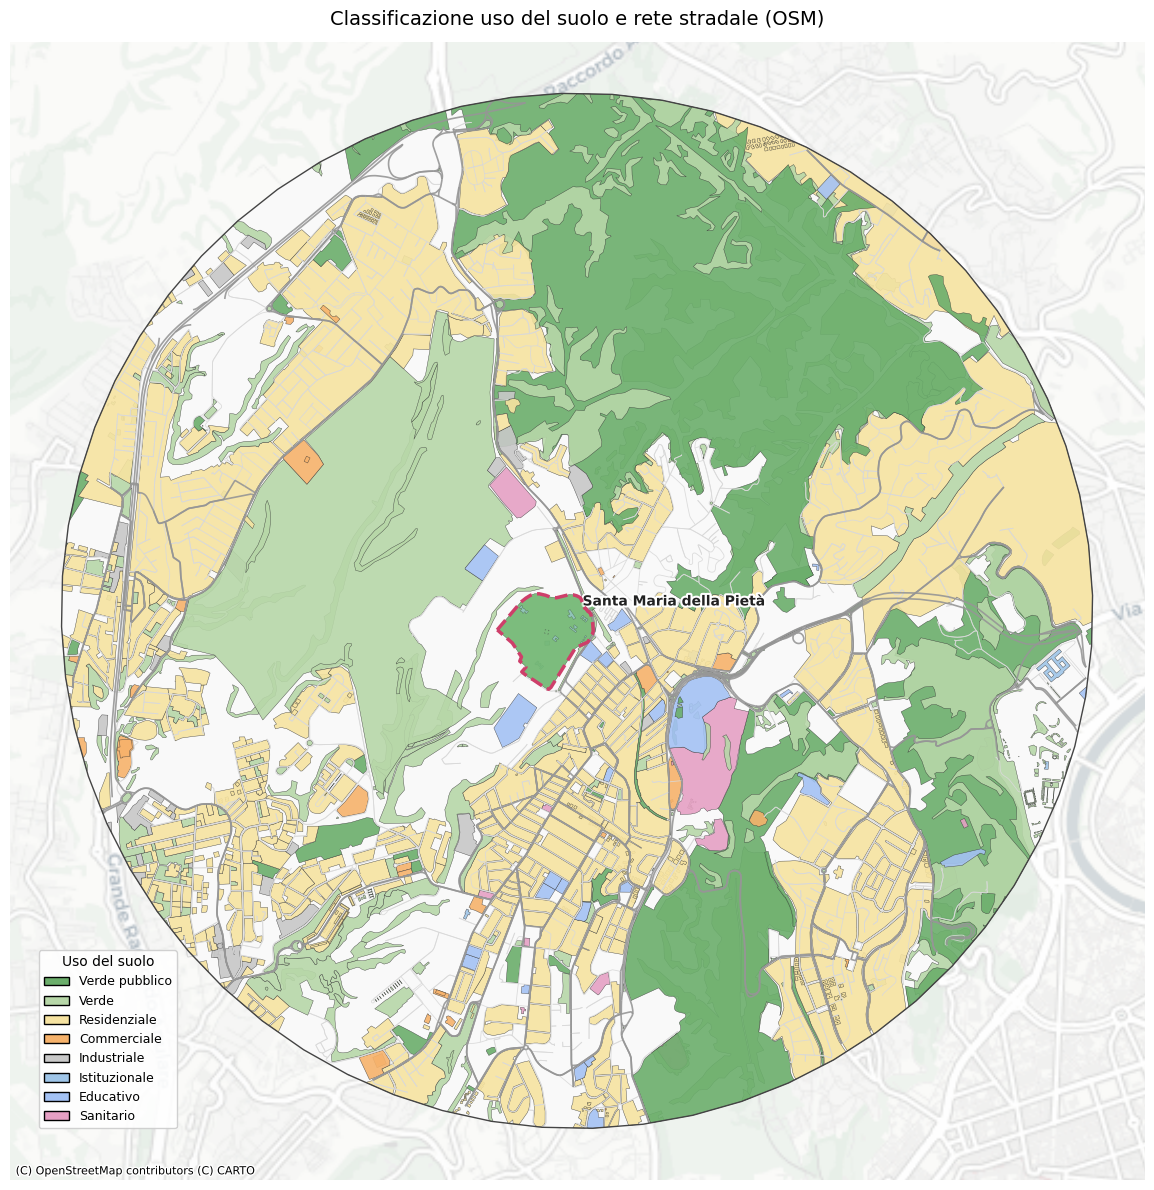

In [23]:
import matplotlib.patheffects as pe
from shapely.geometry import Point
from matplotlib.patches import Patch

# === PALETTE AGGIORNATA ===
palette_landuse = {
    "Verde pubblico": "#6BAE6B",
    "Verde": "#B7D7A8",
    "Residenziale": "#F6E3A1",
    "Commerciale": "#F6B26B",
    "Industriale": "#C8C8C8",
    "Istituzionale": "#9FC5E8",
    "Educativo": "#A4C2F4",
    "Sanitario": "#E6A0C4",
    "Non classificato": "#DADADA"
}

# === 1. Crea la figura ===
fig, ax = plt.subplots(figsize=(12, 12))

# --- Sfondo neutro ---
aoi3857.plot(ax=ax, color="#F9F9F9", zorder=-5)

# --- Poligoni classificati ---
gdf_classified_3857.plot(
    ax=ax,
    column="landuse_class",
    color=gdf_classified_3857["landuse_class"].map(palette_landuse),
    legend=False,
    alpha=0.9,
    edgecolor="#333333",
    linewidth=0.3,
    zorder=10
)

# --- Strade ---
if not edges_minor3857.empty:
    edges_minor3857.plot(ax=ax, color="#d9d9d9", linewidth=0.6, alpha=0.9, zorder=30)
if not edges_major3857.empty:
    edges_major3857.plot(ax=ax, color="#969696", linewidth=1.2, alpha=0.9, zorder=40)

# --- AOI (contorno) ---
aoi3857.boundary.plot(ax=ax, color="#444444", linewidth=1.0, zorder=50)

# --- Basemap ---
if PARAMS["use_basemap"] and HAS_CTX:
    basemap_key = PARAMS.get("basemap", "positron").lower()
    basemap = BASEMAP_PROVIDERS.get(basemap_key, ctx.providers.CartoDB.Positron)
    ctx.add_basemap(ax, source=basemap, crs=gdf_classified_3857.crs, zorder=-10)

# --- Punto centrale ---
point_geom = Point(PARAMS["center_latlon"][1], PARAMS["center_latlon"][0])  # (lon, lat)
point_3857 = gpd.GeoDataFrame(geometry=[point_geom], crs=4326).to_crs(3857)
x, y = point_3857.geometry.x.iloc[0], point_3857.geometry.y.iloc[0]
p = point_3857.geometry.iloc[0]

# === Trova la geometria "verde" che contiene/interseca il punto ===
mask_verde = gdf_classified_3857["landuse_class"].isin(["Verde", "Verde pubblico"])
gdf_verde = gdf_classified_3857[mask_verde]
gdf_verde_hit = gdf_verde[gdf_verde.intersects(p)].copy()

# === Evidenzia la geometria del Comprensorio ===
if not gdf_verde_hit.empty:
    gdf_verde_hit.boundary.plot(
        ax=ax,
        color="#CE3F6A",
        linewidth=2.5,
        linestyle="--",
        zorder=150
    )
    gdf_verde_hit.plot(
        ax=ax,
        color="#81C784",
        alpha=0.4,
        edgecolor=None,
        zorder=140
    )

# --- Etichetta: solo testo, senza stella ---
ax.text(
    x + 50, y + 50, "Santa Maria della Pietà",
    fontsize=10, fontweight='bold', color='#222222',
    path_effects=[pe.withStroke(linewidth=3, foreground="white")],
    zorder=101
)

# === Legenda ===
order = [
    "Verde pubblico", "Verde",
    "Residenziale", "Commerciale", "Industriale",
    "Istituzionale", "Educativo", "Sanitario", "Non classificato"
]

legend_labels = [
    Patch(facecolor=palette_landuse[label], edgecolor="k", label=label)
    for label in order if label in gdf_classified_3857["landuse_class"].unique()
]

ax.legend(
    handles=legend_labels,
    title="Uso del suolo",
    loc="lower left",
    bbox_to_anchor=(0.02, 0.04),
    fontsize=9,
    title_fontsize=10,
    frameon=True,
    facecolor="white",
    framealpha=0.9
)

# === Titolo e output ===
ax.set_title("Classificazione uso del suolo e rete stradale (OSM)", fontsize=14, pad=12)
ax.set_axis_off()
plt.tight_layout()
# plt.savefig("mappa_landuse_smdp.png", dpi=200, bbox_inches="tight")
plt.show()


In [24]:
# === Escludi POI senza nome valido ===
import numpy as np
poi_df = gdf_classified.copy()
poi_df = poi_df[poi_df["name"].notna() & (poi_df["name"].str.strip() != "")].copy()

# === Info aggiuntive
poi_df["geometry_type"] = poi_df.geometry.geom_type
poi_df["centroide"] = poi_df.geometry.centroid
poi_df["x"] = poi_df["centroide"].x
poi_df["y"] = poi_df["centroide"].y

campi_utili = [
    "name",
    "landuse_class",
    "landuse", "amenity", "leisure", "building", "natural",
    "access", "operator",
    "geometry_type", "x", "y"
]
# === Assegna ID numerico
poi_df = poi_df.reset_index(drop=True)
poi_df["poi_id"] = np.arange(1, len(poi_df) + 1)

poi_df = poi_df[campi_utili + ["geometry", "poi_id"]]



poi_df

name   landuse_class     landuse  \
0                                            RAI     Industriale         NaN   
1                                    Gioielleira     Commerciale         NaN   
2                Riserva Naturale di Monte Mario  Verde pubblico         NaN   
3                          Parco Gabriele Sandri  Verde pubblico         NaN   
4                           Parco della Vittoria  Verde pubblico         NaN   
..                                           ...             ...         ...   
119                    Ospedale San Filippo Neri       Sanitario         NaN   
120                        Area Verde Via Tarsia           Verde         NaN   
121  Parco Ole Kirk Kristiansen - Fondatore LEGO  Verde pubblico         NaN   
122                      Parco Giochi di Ottavia  Verde pubblico         NaN   
123                  Centro Commerciale Gulliver     Commerciale  commercial   

      amenity leisure    building natural access     operator geometry_type  \
0         NaN     NaN  industrial     NaN    NaN          NaN       Polygon   
1         NaN     NaN      retail     NaN    NaN          NaN       Polygon   
2         NaN    park         NaN     NaN    NaN  Roma Natura  MultiPolygon   
3         NaN    park         NaN     NaN    NaN          NaN       Polygon   
4         NaN    park         NaN     NaN    NaN          NaN       Polygon   
..        ...     ...         ...     ...    ...          ...           ...   
119  hospital     NaN         NaN     NaN    NaN   ASL Roma 1       Polygon   
120       NaN  garden         NaN     NaN    yes          NaN       Polygon   
121       NaN    park         NaN     NaN    NaN          NaN  MultiPolygon   
122       NaN    park         NaN     NaN    NaN          NaN       Polygon   
123       NaN     NaN         yes     NaN    NaN          NaN       Polygon   

             x          y                                           geometry  \
0    12.445576  41.919410  POLYGON ((12.44587 41.91959, 12.44586 41.91956...   
1    12.440994  41.919174  POLYGON ((12.44083 41.91928, 12.44088 41.9194,...   
2    12.450831  41.932227  MULTIPOLYGON (((12.44502 41.93231, 12.44533 41...   
3    12.448424  41.924130  POLYGON ((12.44866 41.92481, 12.44873 41.92468...   
4    12.449341  41.924346  POLYGON ((12.44865 41.92355, 12.44875 41.92386...   
..         ...        ...                                                ...   
119  12.413680  41.947707  POLYGON ((12.41557 41.94725, 12.41554 41.94708...   
120  12.405005  41.961918  POLYGON ((12.40478 41.96221, 12.40545 41.96199...   
121  12.378167  41.947776  MULTIPOLYGON (((12.37724 41.94471, 12.37709 41...   
122  12.394737  41.959162  POLYGON ((12.39528 41.95931, 12.39511 41.95919...   
123  12.398688  41.958647  POLYGON ((12.39815 41.95919, 12.39874 41.95884...   

     poi_id  
0         1  
1         2  
2         3  
3         4  
4         5  
..      ...  
119     120  
120     121  
121     122  
122     123  
123     124  

[124 rows x 14 columns]

## POI SELECTION

In [28]:
# Lista di ID scelti manualmente (oppure filtrali per distanza, categoria ecc.)
poi_inclusi_id = [1, 3, 10, 13, 11, 14, 26, 27, 29, 46, 51, 57, 95, 102, 111, 120]  # es. quelli che ti interessano
poi_selected = poi_df[poi_df["poi_id"].isin(poi_inclusi_id)].copy()
poi_selected.head(3)

name   landuse_class landuse amenity leisure  \
0                              RAI     Industriale     NaN     NaN     NaN   
2  Riserva Naturale di Monte Mario  Verde pubblico     NaN     NaN    park   
9                 Pineta Sacchetti           Verde     NaN     NaN     NaN   

     building natural access     operator geometry_type          x          y  \
0  industrial     NaN    NaN          NaN       Polygon  12.445576  41.919410   
2         NaN     NaN    NaN  Roma Natura  MultiPolygon  12.450831  41.932227   
9         NaN    wood    NaN          NaN       Polygon  12.425350  41.909756   

                                            geometry  poi_id  
0  POLYGON ((12.44587 41.91959, 12.44586 41.91956...       1  
2  MULTIPOLYGON (((12.44502 41.93231, 12.44533 41...       3  
9  POLYGON ((12.42473 41.90989, 12.42485 41.90992...      10

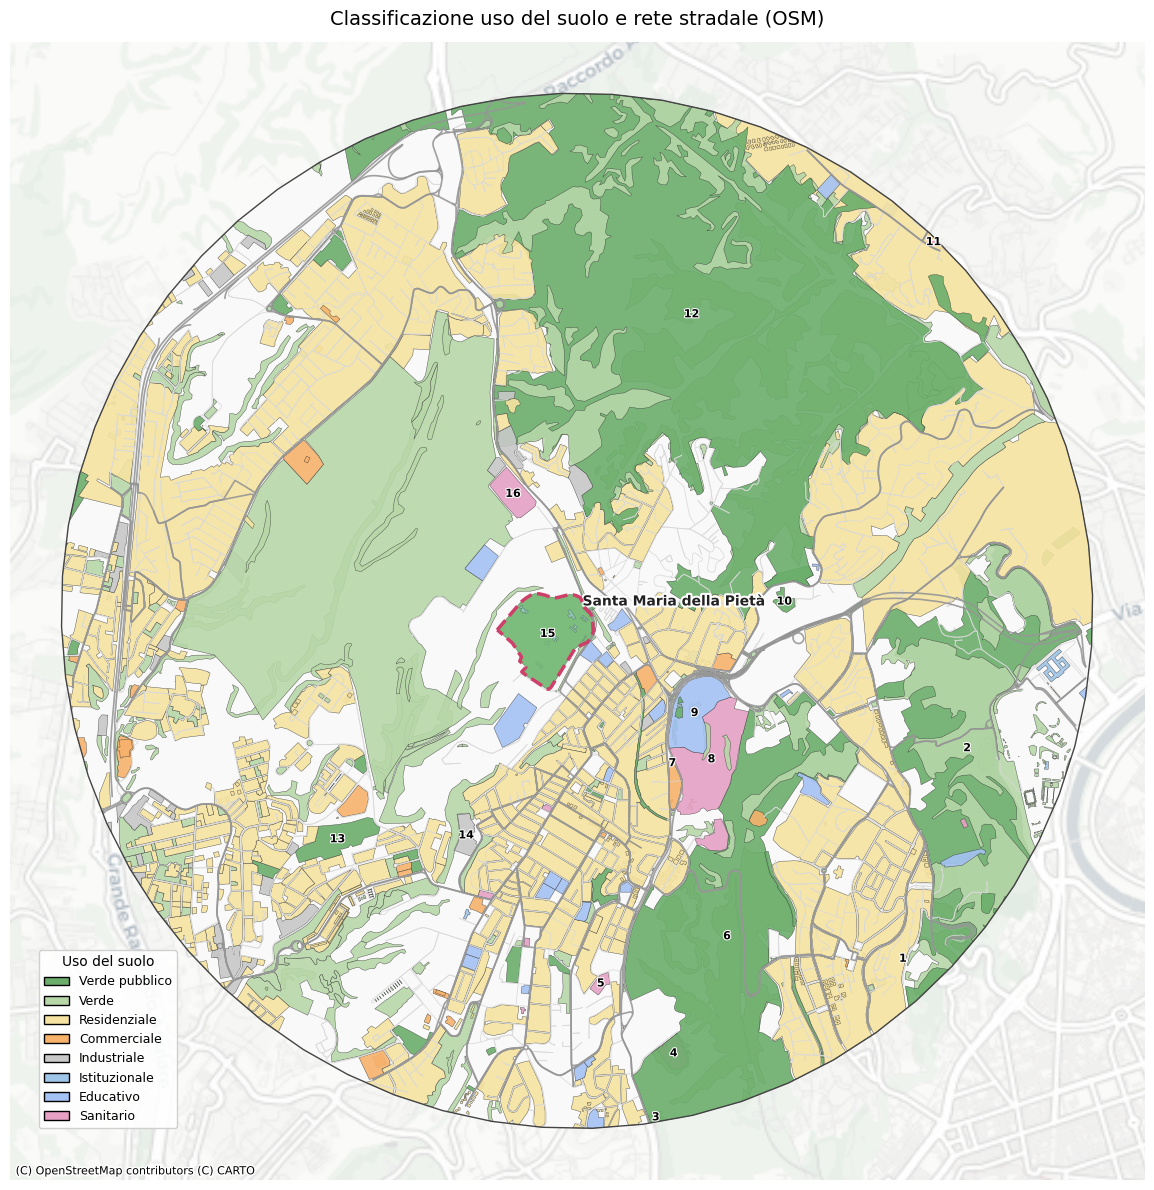

In [33]:
import matplotlib.patheffects as pe
from shapely.geometry import Point
from matplotlib.patches import Patch

# === PALETTE AGGIORNATA ===
palette_landuse = {
    "Verde pubblico": "#6BAE6B",
    "Verde": "#B7D7A8",
    "Residenziale": "#F6E3A1",
    "Commerciale": "#F6B26B",
    "Industriale": "#C8C8C8",
    "Istituzionale": "#9FC5E8",
    "Educativo": "#A4C2F4",
    "Sanitario": "#E6A0C4",
    "Non classificato": "#DADADA"
}

# === 1. Crea la figura ===
fig, ax = plt.subplots(figsize=(12, 12))

# --- Sfondo neutro ---
aoi3857.plot(ax=ax, color="#F9F9F9", zorder=-5)

# --- Poligoni classificati ---
gdf_classified_3857.plot(
    ax=ax,
    column="landuse_class",
    color=gdf_classified_3857["landuse_class"].map(palette_landuse),
    legend=False,
    alpha=0.9,
    edgecolor="#333333",
    linewidth=0.3,
    zorder=10
)

# --- Strade ---
if not edges_minor3857.empty:
    edges_minor3857.plot(ax=ax, color="#d9d9d9", linewidth=0.6, alpha=0.9, zorder=30)
if not edges_major3857.empty:
    edges_major3857.plot(ax=ax, color="#969696", linewidth=1.2, alpha=0.9, zorder=40)

# --- AOI (contorno) ---
aoi3857.boundary.plot(ax=ax, color="#444444", linewidth=1.0, zorder=50)

# --- Basemap ---
if PARAMS["use_basemap"] and HAS_CTX:
    basemap_key = PARAMS.get("basemap", "positron").lower()
    basemap = BASEMAP_PROVIDERS.get(basemap_key, ctx.providers.CartoDB.Positron)
    ctx.add_basemap(ax, source=basemap, crs=gdf_classified_3857.crs, zorder=-10)

# --- Punto centrale ---
point_geom = Point(PARAMS["center_latlon"][1], PARAMS["center_latlon"][0])  # (lon, lat)
point_3857 = gpd.GeoDataFrame(geometry=[point_geom], crs=4326).to_crs(3857)
x, y = point_3857.geometry.x.iloc[0], point_3857.geometry.y.iloc[0]
p = point_3857.geometry.iloc[0]

# === Trova la geometria "verde" che contiene/interseca il punto ===
mask_verde = gdf_classified_3857["landuse_class"].isin(["Verde", "Verde pubblico"])
gdf_verde = gdf_classified_3857[mask_verde]
gdf_verde_hit = gdf_verde[gdf_verde.intersects(p)].copy()

# === Evidenzia la geometria del Comprensorio ===
if not gdf_verde_hit.empty:
    gdf_verde_hit.boundary.plot(
        ax=ax,
        color="#CE3F6A",
        linewidth=2.5,
        linestyle="--",
        zorder=150
    )
    gdf_verde_hit.plot(
        ax=ax,
        color="#81C784",
        alpha=0.4,
        edgecolor=None,
        zorder=140
    )

# --- Etichetta: solo testo, senza stella ---
ax.text(
    x + 50, y + 50, "Santa Maria della Pietà",
    fontsize=10, fontweight='bold', color='#222222',
    path_effects=[pe.withStroke(linewidth=3, foreground="white")],
    zorder=101
)

# === POI selezionati (marker rossi centrati) ===

# Assicura che il CRS sia EPSG:3857
poi_selected = poi_selected.to_crs(3857)

# Calcola il centroide per ogni geometria
poi_selected["centroide"] = poi_selected.geometry.centroid

# Plotta i marker centrati sui centroidi
from matplotlib.patches import Circle

# --- Aggiungi numeri con sfondo in stile categoria
for i, (_, row) in enumerate(poi_selected.iterrows(), start=1):
    pt = row["centroide"]
    
    # Colore in base alla categoria (usa "Non classificato" se mancante)
    categoria = row.get("landuse_class", "Non classificato")
    colore_sfondo = palette_landuse.get(categoria, palette_landuse["Non classificato"])

    # Cerchio colorato di sfondo (tipo badge)
    circle = Circle((pt.x, pt.y), radius=20, facecolor=colore_sfondo,
                    edgecolor="white", linewidth=0.8, zorder=199)
    ax.add_patch(circle)
    
    # Testo (numerino centrato) sopra il cerchio
    ax.text(
        pt.x, pt.y, str(i),
        fontsize=8, weight="bold", color="black",
        ha="center", va="center",
        path_effects=[pe.withStroke(linewidth=1.5, foreground="white")],
        zorder=200
    )




# === Legenda ===
order = [
    "Verde pubblico", "Verde",
    "Residenziale", "Commerciale", "Industriale",
    "Istituzionale", "Educativo", "Sanitario", "Non classificato"
]

legend_labels = [
    Patch(facecolor=palette_landuse[label], edgecolor="k", label=label)
    for label in order if label in gdf_classified_3857["landuse_class"].unique()
]

ax.legend(
    handles=legend_labels,
    title="Uso del suolo",
    loc="lower left",
    bbox_to_anchor=(0.02, 0.04),
    fontsize=9,
    title_fontsize=10,
    frameon=True,
    facecolor="white",
    framealpha=0.9
)

# === Titolo e output ===
ax.set_title("Classificazione uso del suolo e rete stradale (OSM)", fontsize=14, pad=12)
ax.set_axis_off()
plt.tight_layout()
# plt.savefig("mappa_landuse_smdp.png", dpi=200, bbox_inches="tight")
plt.show()


## poi plot

In [30]:
import pandas as pd

righe = []
for i, (_, row) in enumerate(poi_selected.iterrows(), start=1):
    # Prendi un nome “robusto” (fallback se manca 'name')
    nome = (row.get("name")
            or row.get("Nome")
            or row.get("label")
            or row.get("ref")
            or "")

    righe.append({
        "numero": i,                         # numero mostrato sul grafico
        "poi_id": row.get("poi_id", None),   # ID interno se presente
        "nome": nome,
        "category": row.get("category", None),
        "landuse_class": row.get("landuse_class", None)
    })

mappa_num_nomi = pd.DataFrame(righe)
print(mappa_num_nomi)
# opzionale: salvalo per controllo
# mappa_num_nomi.to_csv("mappa_poi_numeri.csv", index=False)


    numero  poi_id                                        nome category  \
0        1       1                                         RAI     None   
1        2       3             Riserva Naturale di Monte Mario     None   
2        3      10                            Pineta Sacchetti     None   
3        4      11       ASL RME - Dipartimento salute mentale     None   
4        5      13                          Ospedale Cristo Re     None   
5        6      14           Parco Regionale Urbano del Pineto     None   
6        7      26                      Hospice Villa Speranza     None   
7        8      27  Policlinico Universitario Agostino Gemelli     None   
8        9      29        Università Cattolica del Sacro Cuore     None   
9       10      46                                Happy Family     None   
10      11      51        Ospedale San Pietro Fatebenefratelli     None   
11      12      57           Riserva Naturale dell'Insugherata     None   
12      13      95       

In [31]:
from IPython.display import HTML, display

# 1) Seleziona solo le colonne necessarie e ordina per numero
tab = (
    mappa_num_nomi[["numero", "nome"]]
    .sort_values("numero")
    .rename(columns={"numero": "#", "nome": "POI"})
)

# 2) HTML + CSS minimale
css = """
<style>
table.tbl { border-collapse: collapse; font-family: system-ui, sans-serif; font-size: 14px; }
table.tbl th, table.tbl td { padding: 6px 10px; border-bottom: 1px solid #ddd; }
table.tbl tr:nth-child(even) { background: #fafafa; }
table.tbl th { text-align: left; }
caption { caption-side: top; text-align: left; font-weight: 600; margin-bottom: 6px; }
</style>
"""

html_table = tab.to_html(index=False, escape=True, border=0, classes="tbl")
html = css + "<caption>Mappa POI: numero ↔ nome</caption>" + html_table

# 3) Salva su file
with open("mappa_poi_numeri.html", "w", encoding="utf-8") as f:
    f.write(html)

# 4) (opzionale) mostra in notebook
display(HTML(html))

print("Creato file: mappa_poi_numeri.html")


Creato file: mappa_poi_numeri.html


## edifici

In [34]:
import osmnx as ox
import geopandas as gpd

# 1) AOI in WGS84 come (Multi)Polygon shapely
aoi_wgs84_geom = aoi3857.to_crs(4326).unary_union  # shapely (Polygon/MultiPolygon)

# 2) Fetch buildings (compatibile v1.x / v2.x)
if hasattr(ox, "features_from_polygon"):
    buildings = ox.features_from_polygon(aoi_wgs84_geom, tags={"building": True})
else:
    buildings = ox.geometries_from_polygon(aoi_wgs84_geom, tags={"building": True})

# 3) Tieni solo poligoni e proietta a 3857
buildings = buildings[buildings.geometry.geom_type.isin(["Polygon", "MultiPolygon"])].copy()
buildings3857 = buildings.to_crs(3857)

# 4) Clip all’AOI (opzionale ma consigliato)
try:
    buildings3857 = gpd.clip(buildings3857, aoi3857)
except Exception:
    pass

# 5) Plot “soft” (sotto le strade)
if not buildings3857.empty:
    buildings3857.plot(
        ax=ax,
        color="#000000",      # nero con alpha bassa = grigio tenue
        alpha=0.06,
        edgecolor="#777777",
        linewidth=0.15,
        zorder=25             # > landuse (10), < strade (30/40)
    )


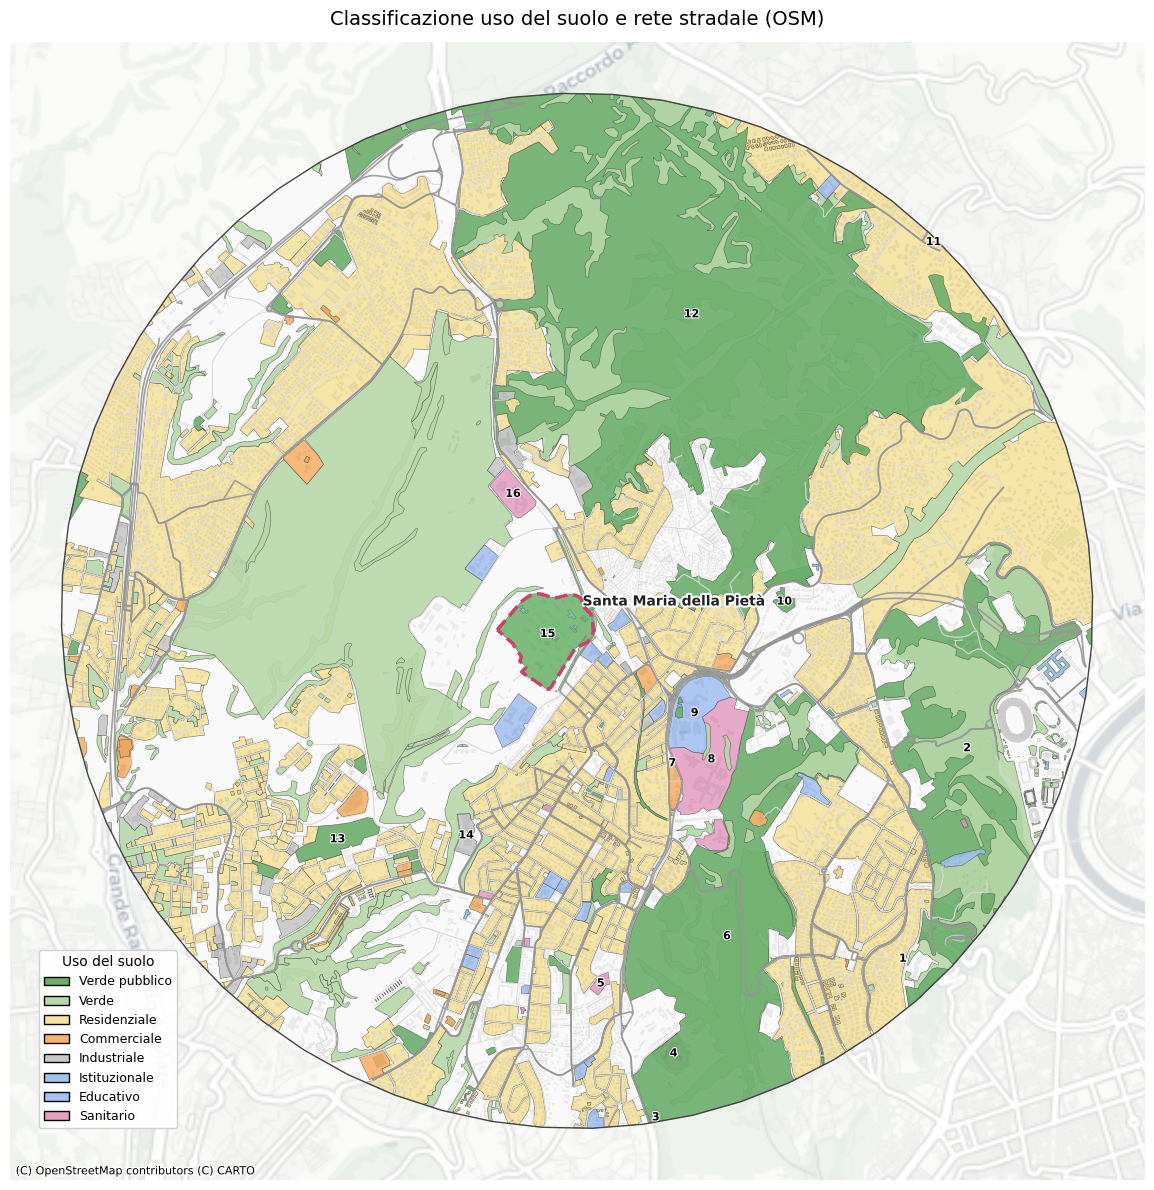

In [36]:
import matplotlib.patheffects as pe
from shapely.geometry import Point
from matplotlib.patches import Patch

# === PALETTE AGGIORNATA ===
palette_landuse = {
    "Verde pubblico": "#6BAE6B",
    "Verde": "#B7D7A8",
    "Residenziale": "#F6E3A1",
    "Commerciale": "#F6B26B",
    "Industriale": "#C8C8C8",
    "Istituzionale": "#9FC5E8",
    "Educativo": "#A4C2F4",
    "Sanitario": "#E6A0C4",
    "Non classificato": "#DADADA"
}

# === 1. Crea la figura ===
fig, ax = plt.subplots(figsize=(12, 12))

# --- Sfondo neutro ---
aoi3857.plot(ax=ax, color="#F9F9F9", zorder=-5)

# --- Poligoni classificati ---
gdf_classified_3857.plot(
    ax=ax,
    column="landuse_class",
    color=gdf_classified_3857["landuse_class"].map(palette_landuse),
    legend=False,
    alpha=0.9,
    edgecolor="#333333",
    linewidth=0.3,
    zorder=10
)

# --- Edifici (soft) ---
# Se hai già un GeoDataFrame buildings3857 nel tuo notebook:
b = locals().get("buildings3857", None)

# In caso contrario, prova a scaricarli da OSM (serve internet)
if b is None:
    import osmnx as ox
    aoi_wgs84_geom = aoi3857.to_crs(4326).unary_union
    if hasattr(ox, "features_from_polygon"):
        b_raw = ox.features_from_polygon(aoi_wgs84_geom, tags={"building": True})
    else:
        b_raw = ox.geometries_from_polygon(aoi_wgs84_geom, tags={"building": True})
    b = b_raw[b_raw.geometry.geom_type.isin(["Polygon", "MultiPolygon"])].to_crs(3857)
    try:
        import geopandas as gpd
        b = gpd.clip(b, aoi3857)
    except Exception:
        pass

if b is not None and not b.empty:
    b.plot(
        ax=ax,
        color="#000000",   # nero con alpha bassa -> grigio tenue
        alpha=0.06,
        edgecolor="#777777",
        linewidth=0.15,
        zorder=25          # > landuse (10), < strade (30/40)
    )


# --- Strade ---
if not edges_minor3857.empty:
    edges_minor3857.plot(ax=ax, color="#d9d9d9", linewidth=0.6, alpha=0.9, zorder=30)
if not edges_major3857.empty:
    edges_major3857.plot(ax=ax, color="#969696", linewidth=1.2, alpha=0.9, zorder=40)

# --- AOI (contorno) ---
aoi3857.boundary.plot(ax=ax, color="#444444", linewidth=1.0, zorder=50)

# --- Basemap ---
if PARAMS["use_basemap"] and HAS_CTX:
    basemap_key = PARAMS.get("basemap", "positron").lower()
    basemap = BASEMAP_PROVIDERS.get(basemap_key, ctx.providers.CartoDB.Positron)
    ctx.add_basemap(ax, source=basemap, crs=gdf_classified_3857.crs, zorder=-10)

# --- Punto centrale ---
point_geom = Point(PARAMS["center_latlon"][1], PARAMS["center_latlon"][0])  # (lon, lat)
point_3857 = gpd.GeoDataFrame(geometry=[point_geom], crs=4326).to_crs(3857)
x, y = point_3857.geometry.x.iloc[0], point_3857.geometry.y.iloc[0]
p = point_3857.geometry.iloc[0]

# === Trova la geometria "verde" che contiene/interseca il punto ===
mask_verde = gdf_classified_3857["landuse_class"].isin(["Verde", "Verde pubblico"])
gdf_verde = gdf_classified_3857[mask_verde]
gdf_verde_hit = gdf_verde[gdf_verde.intersects(p)].copy()

# === Evidenzia la geometria del Comprensorio ===
if not gdf_verde_hit.empty:
    gdf_verde_hit.boundary.plot(
        ax=ax,
        color="#CE3F6A",
        linewidth=2.5,
        linestyle="--",
        zorder=150
    )
    gdf_verde_hit.plot(
        ax=ax,
        color="#81C784",
        alpha=0.4,
        edgecolor=None,
        zorder=140
    )

# --- Etichetta: solo testo, senza stella ---
ax.text(
    x + 50, y + 50, "Santa Maria della Pietà",
    fontsize=10, fontweight='bold', color='#222222',
    path_effects=[pe.withStroke(linewidth=3, foreground="white")],
    zorder=101
)

# === POI selezionati (marker rossi centrati) ===

# Assicura che il CRS sia EPSG:3857
poi_selected = poi_selected.to_crs(3857)

# Calcola il centroide per ogni geometria
poi_selected["centroide"] = poi_selected.geometry.centroid

# Plotta i marker centrati sui centroidi
from matplotlib.patches import Circle

# --- Aggiungi numeri con sfondo in stile categoria
for i, (_, row) in enumerate(poi_selected.iterrows(), start=1):
    pt = row["centroide"]
    
    # Colore in base alla categoria (usa "Non classificato" se mancante)
    categoria = row.get("landuse_class", "Non classificato")
    colore_sfondo = palette_landuse.get(categoria, palette_landuse["Non classificato"])

    # Cerchio colorato di sfondo (tipo badge)
    circle = Circle((pt.x, pt.y), radius=20, facecolor=colore_sfondo,
                    edgecolor="white", linewidth=0.8, zorder=199)
    ax.add_patch(circle)
    
    # Testo (numerino centrato) sopra il cerchio
    ax.text(
        pt.x, pt.y, str(i),
        fontsize=8, weight="bold", color="black",
        ha="center", va="center",
        path_effects=[pe.withStroke(linewidth=1.5, foreground="white")],
        zorder=200
    )




# === Legenda ===
order = [
    "Verde pubblico", "Verde",
    "Residenziale", "Commerciale", "Industriale",
    "Istituzionale", "Educativo", "Sanitario", "Non classificato"
]

legend_labels = [
    Patch(facecolor=palette_landuse[label], edgecolor="k", label=label)
    for label in order if label in gdf_classified_3857["landuse_class"].unique()
]

ax.legend(
    handles=legend_labels,
    title="Uso del suolo",
    loc="lower left",
    bbox_to_anchor=(0.02, 0.04),
    fontsize=9,
    title_fontsize=10,
    frameon=True,
    facecolor="white",
    framealpha=0.9
)

# === Titolo e output ===
ax.set_title("Classificazione uso del suolo e rete stradale (OSM)", fontsize=14, pad=12)
ax.set_axis_off()
plt.tight_layout()
# plt.savefig("mappa_landuse_smdp.png", dpi=200, bbox_inches="tight")
plt.show()

